|평가문항|상세기준|
|---|---|
|1. multiface detection을 위한 widerface 데이터셋의 전처리가 적절히 진행되었다.|tfrecord 생성, augmentation, prior box 생성 등의 과정이 정상적으로 진행되었다.|
|2. SSD 모델이 안정적으로 학습되어 multiface detection이 가능해졌다.|inference를 통해 정확한 위치의 face bounding box를 detect한 결과이미지가 제출되었다.|
|3. 이미지 속 다수의 얼굴에 스티커가 적용되었다.|이미지 속 다수의 얼굴의 적절한 위치에 스티커가 적용된 결과이미지가 제출되었다.|

<!-- x0, y0, w, h, blur, expression, illumination, invalid, occlusion, pose -->

필요한 라이브러리와 전역 변수를 준비

In [23]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


In [24]:
from dataset_parser import (
    get_box as parse_box, parse_widerface, 
    process_image, xywh_to_voc,
    make_example
)

dataset parsing 테스트

In [25]:
from dataset_parser import (
    parse_widerface, process_image, xywh_to_voc
)

file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 2:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

---
### TFRecord 생성
TFRecord는 여러 개의 tf.train.Example로 이루어져 있고, 한 개의 tf.train.Example은 여러 개의 tf.train.Feature로 이루어져 있음.

데이터의 단위를 이루는 tf.train.Example 인스턴스를 생성하는 메소드

In [ ]:
from dataset_parser import (
    parse_widerface, 
    process_image, 
    xywh_to_voc,
    make_example
)

import tqdm

for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

아래에 있는 실행문으로 모듈화되어있는 dataset preprocessing을 수행할 수 있다.

In [11]:
!python $(pwd)/dataset_parser.py

100%|██████████████████████████████████████| 3226/3226 [00:13<00:00, 234.97it/s]


In [10]:
!ls ~/aiffel/face_detector/dataset

train_mask.tfrecord  val_mask.tfrecord


[루브릭 1-1]tfrecord 생성

### augmentation 적용

- crop
- pad to square
- resize
- flip
- distort

In [ ]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        """
        return iof of a and b, numpy version for data augenmentation
        """
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)


        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

In [ ]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)

    return img

In [ ]:
def _resize(img, labels, img_dim):
    ''' # resize and boxes coordinate to percent'''
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)
    if isinstance(img_dim, int):
        img_dim = (img_dim, img_dim)
    elif isinstance(img_dim,tuple):
        img_dim = img_dim
    else:
        raise Exception('Type error of input image size format,tuple or int. ')

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [img_dim[0], img_dim[1]], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

In [ ]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

In [ ]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

```python
def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if using_crop:
        # randomly crop
            img, labels = _crop(img, labels)

            # padding to square
            img = _pad_to_square(img)

        # resize and boxes coordinate to percent
        img, labels = _resize(img, labels, img_dim)

        # randomly left-right flip
        if using_flip:
            img, labels = _flip(img, labels)

        # distort
        if using_distort:
            img = _distort(img)

        # encode labels to feature targets
        if using_encoding:
            labels = encode_tf(labels=labels, priors=priors, match_thresh=match_thresh, variances=variances)
        if using_normalizing:
            img=(img/255.0-0.5)/1.0

        return img, labels
```

### prior box 생성

Default box

In [22]:
from make_prior_box import prior_box

import config
priors, num_cell = prior_box(config.cfg)
# image_sizes = cfg['input_size']
# min_sizes=cfg["min_sizes"]
# steps=cfg["steps"]
# clip=cfg["clip"]  # clip output or not

print(priors.shape, num_cell)

(4420, 4) [3, 2, 2, 3]


In [13]:
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

In [15]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

In [17]:
default_box()

array([[0.0125   , 0.015625 , 0.03125  , 0.0390625],
       [0.0125   , 0.015625 , 0.05     , 0.0625   ],
       [0.0125   , 0.015625 , 0.075    , 0.09375  ],
       ...,
       [0.9      , 0.875    , 0.4      , 0.5      ],
       [0.9      , 0.875    , 0.6      , 0.75     ],
       [0.9      , 0.875    , 0.8      , 1.       ]])

[루브릭 1-3] prior box 생성

### SSD 모델 학습

##### model build

In [25]:
from tf_build_ssd_model import SsdModel
import config
import os

cfg = config.cfg
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = SsdModel(cfg, num_cell=[3, 2, 2, 3],training=False)
print('The number of layers in SSD model: {}'.format(len(model.layers)))
model.summary()

The number of layers in SSD model: 101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_pad_43 (ZeroPadding2D)     (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv_43 (Conv2D)                (None, None, None, 1 432         conv_pad_43[0][0]                
__________________________________________________________________________________________________
conv_bn_43 (BatchNormalization) (None, None, None, 1 64          conv_43[0][0]                    
___________________________________________________

model training

In [23]:
from tf_dataloader import load_dataset 


In [1]:
from train import main as train_model
train_model(None)

Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 242, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 120, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 120, 160, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________

Epoch: 1/100 | Batch 402/402 | Batch time 0.096 || Loss: nan | loc loss:nan | class loss:nan 796 s:2.624550  
Epoch: 1/100  | Epoch time 128.495 || Average Loss: nan
Epoch: 2/100 | Batch 402/402 | Batch time 0.096 || Loss: nan | loc loss:nan | class loss:nan 
Epoch: 2/100  | Epoch time 119.957 || Average Loss: nan
Epoch: 3/100 | Batch 402/402 | Batch time 0.121 || Loss: nan | loc loss:nan | class loss:nan 
Epoch: 3/100  | Epoch time 120.219 || Average Loss: nan
Epoch: 4/100 | Batch 140/402 | Batch time 0.118 || Loss: nan | loc loss:nan | class loss:nan interrupted


NameError: name 'exit' is not defined

[루브릭 2-1] SSD 모델이 안정적으로 학습되었다.

### Step 2. SSD 모델을 통해 얼굴 bounding box 찾기

1)위에서 학습 완료된 SSD 모델을 불러와 2)주어진 image 파일에 존재하는 얼굴에 대한 bounding box를 찾는다.

- 모델이 예측하는 많은 box 들 중에 하나의 box를 추려내기 위해서 NMS 알고리즘을 사용한다.


In [10]:
!python inference.py checkpoints/ image.png

model path : checkpoints/weights_epoch_008.h5
[*] Predict image.png image.. 
(256, 320, 3)
scores:[0.7817987  0.7050888  0.6985176  0.66755486 0.64852124 0.62554085
 0.58893836 0.58019066 0.5564894 ]


### Multiface detection 

#### load model

In [1]:
from tf_build_ssd_model import SsdModel
import os

def load_model(model_path, cfg):
    min_sizes=cfg['min_sizes']
    num_cell = [len(min_sizes[k]) for k in range(len(cfg['steps']))]

    model = SsdModel(cfg=cfg, num_cell=num_cell, training=False)

    paths = [os.path.join(model_path, path)
             for path in os.listdir(model_path)]
    latest = sorted(paths, key=os.path.getmtime)[-1]
    model.load_weights(latest)
    print(f"model path : {latest}")
    
    return model

In [2]:
import config
model_path = 'checkpoints/'
cfg = config.cfg
model = load_model(model_path, cfg)

model path : checkpoints/weights_epoch_008.h5


#### inference with loaded model

In [3]:
import cv2
import numpy as np

In [4]:
from inference import pad_input_image, parse_predict, recover_pad_output, show_image
from make_prior_box import prior_box
import tensorflow as tf

In [5]:
def show_image(img, boxes, classes, scores, img_height, img_width, prior_index, class_list):
    """
    draw bboxes and labels
    out:boxes,classes,scores
    """
    # bbox

    x1, y1, x2, y2 = int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height), \
                     int(boxes[prior_index][2] * img_width), int(boxes[prior_index][3] * img_height)
    if classes[prior_index] == 1:
        color = (0, 255, 0) # green
    else:
        color = (0, 0, 255) # red
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    # confidence
    if any(scores):  ### Modification
        score = "{:.4f}".format(scores[prior_index])
        class_name = class_list[classes[prior_index]]

        cv2.putText(img, '{} {}'.format(class_name, score),
                    (int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height) - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

추출된 정보를 실제 이미지 정보와 결합: `show_image` 함수에서 원본 이미지에 box 정보를 사각형으로 표시(`L14`)한다.

오류 발생에서 다음으로 처리함. L17: scores -> any(scores)

In [25]:
def finding_box_show_img(model, img_path, cfg, verbose=False):
    if not os.path.exists(img_path):
        print(f"Cannot find image path from {img_path}")
        exit()
    if verbose: print("[*] Predict {} image.. ".format(img_path))
    img_raw = cv2.imread(img_path)
    img_raw = cv2.resize(img_raw, (320, 240))
    img_height_raw, img_width_raw, _ = img_raw.shape
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # pad input image to avoid unmatched shape problem
    img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))
    img = img / 255.0 - 0.5
    if verbose: print('The shape of image:{}'.format(img.shape))
    priors, _ = prior_box(cfg, image_sizes = (img.shape[0], img.shape[1]))
    priors = tf.cast(priors, tf.float32)

    predictions = model.predict(img[np.newaxis, ...])

    boxes, classes, scores = parse_predict(predictions, priors, cfg)

    if verbose: print(f"scores:{scores}")
    # recover padding effect
    boxes = recover_pad_output(boxes, pad_params)

    for prior_index in range(len(scores)):
        show_image(img_raw, boxes, classes, scores, img_height_raw, img_width_raw, prior_index,cfg['labels_list'])
    
    return img_raw, boxes

`L21`:`parse_predict`에서 bounding box 를 선별한다.
- cfg 의 `score_threshold` (default: 0.5),`nms_threshold` (default: 0.4)를 변화시켜 그림에 표시될 bounding box 의 갯수를 조절할 수 있다.



In [26]:
import matplotlib.pyplot as plt

def exp_threshold(img_path, 
                  score_threshold_li = [0.8, 0.7, 0.6, 0.5], 
                  nms_threshold_li = [0.9, 0.4, 0.01] ):

    fig, axs = plt.subplots(nrows=len(score_threshold_li), 
                            ncols=len(nms_threshold_li), 
                            figsize=(16,16)) # w, h

    for i, score_threshold in enumerate(score_threshold_li):
        for j, nms_threshold in enumerate(nms_threshold_li):
            cur_cfg = cfg.copy()
            cur_cfg.update({
                'score_threshold': score_threshold, 
                'nms_threshold': nms_threshold,
            })
            img_raw, boxes = finding_box_show_img(model, img_path, cur_cfg)
            plt.sca(axs[i,j])
            plt.imshow(img_raw[:,:,[2,1,0]])  #BGR -> RGB
            plt.title(f'score_threshold: {score_threshold}\nnms_threshold: {nms_threshold}')

    plt.show()

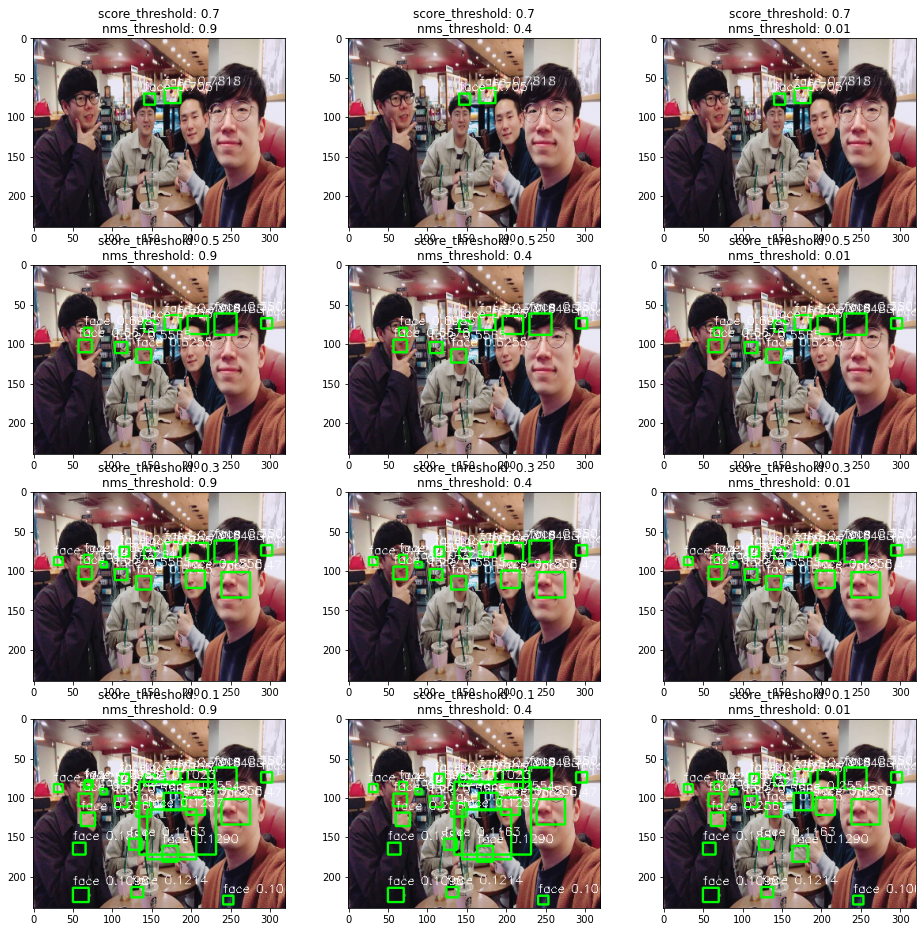

In [27]:
exp_threshold(
    img_path = 'image.png',
    score_threshold_li = [0.7, 0.5, 0.3, 0.1],
    nms_threshold_li = [0.9, 0.4, 0.01],
)

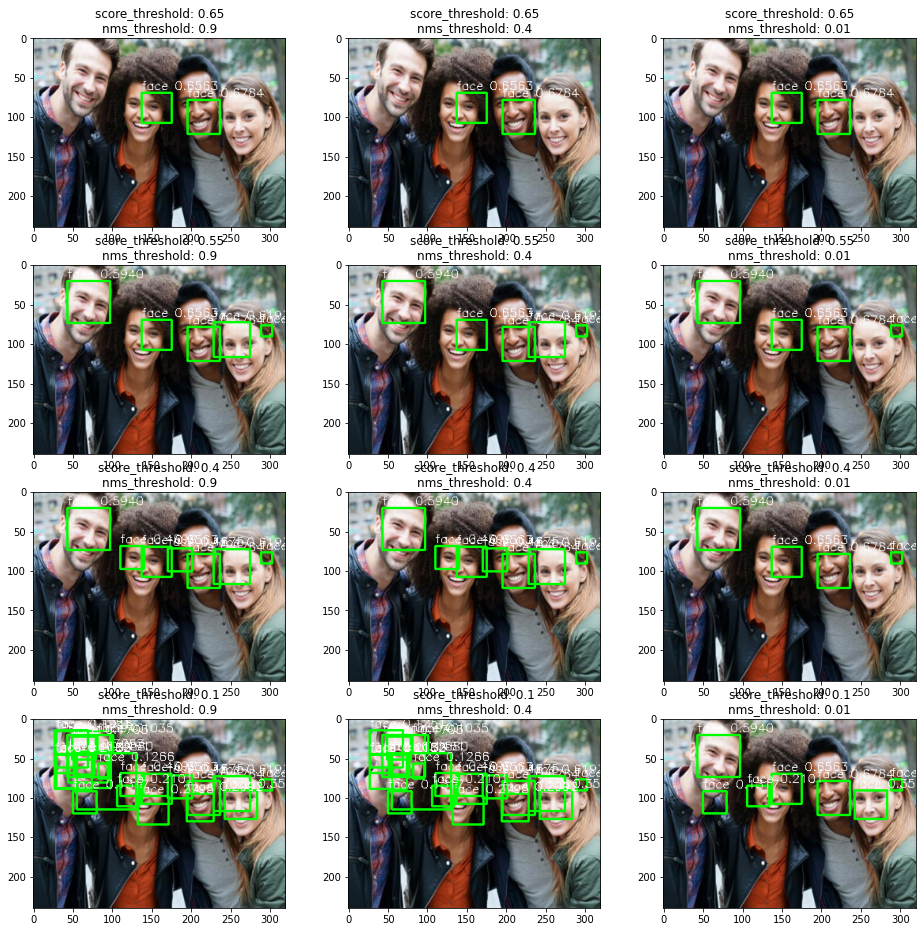

In [24]:
exp_threshold(
    img_path = 'image_people.png',
    score_threshold_li = [0.65, 0.55, 0.4, 0.1],
    nms_threshold_li = [0.9, 0.4, 0.01],
)

In [7]:
img_path = 'image.png'
img_raw = finding_box_show_img(model, img_path, cfg)


# draw and save results
save_img_path = os.path.join('assets/out_' + os.path.basename(img_path))
cv2.imwrite(save_img_path, img_raw)

print(f'image is saved in {save_img_path}')

[*] Predict image.png image.. 
The shape of image:(256, 320, 3)
scores:[0.7817987  0.7050888  0.6985175  0.66755486 0.64852124 0.62554085
 0.58893836 0.58019066 0.5564894 ]
image is saved in assets/out_image.png


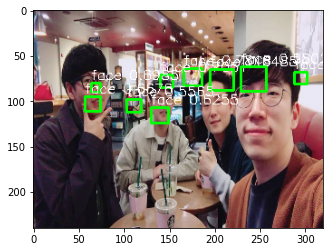

In [8]:
import matplotlib.pyplot as plt
plt.imshow(img_raw[:,:,[2,1,0]])  #BGR -> RGB
plt.show()

[루브릭 2-2] inference를 통해 정확한 위치의 face bounding box를 detect한 결과이미지가 제출
![](assets/out_image.png)

### Step 4. 스티커 합성 사진 생성하기

In [27]:
sticker_path = os.getenv('HOME')+'/aiffel/face_detector/mustache.png' # 고양이 수염 이미지의 경로
img_sticker = cv2.imread(sticker_path, -1) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환b


In [ ]:
def attach_sticker(img_show, x, y, sticker_area, img_sticker, alpha = 0.8 ):
    src2 = img_show.copy()
    src1 = img_show
    beta = 1 - alpha
    
    src2[y:y+img_sticker.shape[0], 
             x:x+img_sticker.shape[1]] = \
        np.where(np.expand_dims(img_sticker[:,:,3]==0,axis=-1),
                 sticker_area,
                 img_sticker[:,:,:3]).astype(np.uint8)
    
    return cv2.addWeighted( src1, alpha, src2, beta, gamma=0.0)

sticker_attached_img_show = attach_sticker(img_show, refined_x, refined_y, sticker_area, img_sticker )

[루브릭 3]미완. ~~이미지 속 다수의 얼굴의 적절한 위치에 스티커가 적용된 결과이미지 제출~~

### 회고

- 배운 점
    - NMS 의 동작 방식을 알았다.
        - Score threshold 낮아질 수록 후보 bbox가 많아진다.
        - Nms threshold 가 높아질수록 NMS 알고리즘에 의해서 살아남는 Bbox가 많아진다.
- 아쉬운 점
    - Loss 값이 nan 이 나오는 오류가 있었으나 해결하지 못하여 model을 Train set 에 대해서 학습하지 못했고, 이로 인해 얼굴 인식을 제대로 하지 못하는 것으로 보였다. (정성 평가 성능이 낮았다.)
    - 시간이 모자라서 인식된 얼굴 부분 (bbox)에 sticker를 넣는 작업을 하지 못했다.
- 느낀 점
    - 디버깅을 하기 위해서 notebook 이 아닌 python script 를 직접 실행하는게 좋았을 것 같다.
        - tensorflow excution stage 에서의 tensor 값에 대한 추적이 가능하므로
- 어려웠던 점
    - 노트북을 사용한 디버깅에 익숙하지 않아 디버깅을 하기 어려웠다.